In [1]:
using Plots
using QuadGK
using NLopt
using SpecialFunctions
using NLsolve
using Measures
include("../../scaling_CGS.jl")

print_basic_info (generic function with 1 method)

In [2]:
#---------- Two Steam Setup ----------
base = BaseUnits("CGS")

electron_mass_scaling = 1e0
charge_scaling = 1e0
eps_0_scaling = 1e0
mu_0_scaling = 1e0

scale_base_units(base, eps_0_scaling, mu_0_scaling, charge_scaling, electron_mass_scaling)

mass_density_scale = 1.673532836356e-14
length_scale       = 227.71078654314857
time_scale         = 1.1137516851221212e-9



length= 227.71078654314857
number_density=1e10
B_flux=10
temperature   = 2.3719594179263036e6  # Corresponds to v_t_e = 0.1*V_0  for V_0 = 0.2*c 
temperature_e = temperature
temperature_p = temperature



scaling = ScalingCGS(base,
                number_density, length, temperature, temperature_e, temperature_p, B_flux,
                length_scale, mass_density_scale, time_scale)

ds = 0.0025
per_cell = 125

set_macro_particle_weights(scaling, ds, per_cell);
#print_all_CGS(scaling)

1.1807305771571771e17

In [3]:
# Penrose criterion function
#   Note, this is based only on electrons and protons are neglected
function Penrose_criterion(U0, V0, v_t)
    function integrand(u)
        p1 = exp(- (u + V0)^2 / (2 * v_t^2))
        p2 = exp(- (u - V0)^2 / (2 * v_t^2))
        p3 = exp(- (U0 + V0)^2 / (2 * v_t^2))
        p4 = exp(- (U0 - V0)^2 / (2 * v_t^2))
        return (p1 + p2 - p3 - p4) / (u - U0)^2
    end

    integral, error = quadgk(integrand, -c*100, c*100) # Multiplying with 10 as in Python code
    return integral, error
end

Penrose_criterion (generic function with 1 method)

In [4]:
#---------- Find unstable limit for "real" physical values --------------

c = scaling.c_real
m_e = scaling.m_e_real

k_B = scaling.k_B_real

V_0 = scaling.c_real * 0.2

U0 = 1e-6 # #Should be zero but integrals crash so just make it a small value compared to the velocities 


#---------- Find zero crossing  ------------------------------
V_t_arr  = collect(range(0.7,stop=0.8, length=10000)) * V_0
Pen_res = zeros(size(V_t_arr))

for (i,v_t) in enumerate(V_t_arr)
    res, err = Penrose_criterion.(U0, V_0, v_t)
    Pen_res[i] = res
end

min_index = argmin(abs.(Pen_res))
v_t_limit = V_t_arr[min_index]
#------------------------------------------------------------

println("Setup is no longer unstable if thermal velocity reaches $(@sprintf("%.2e", v_t_limit)) m/s")
println("Relative to drift this is $(@sprintf("%.5f", v_t_limit / V_0))")
println("This corresponds to a temperature of: $(@sprintf("%.2e", v_t_limit^2 * m_e / k_B)) K")


Setup is no longer unstable if thermal velocity reaches 4.59e+09 m/s
Relative to drift this is 0.76555
This corresponds to a temperature of: 1.39e+08 K


In [5]:
#---------- Find unstable limit for scaled code values --------------

c = scaling.c_code


omega_e = scaling.electron_plasma_freq_code
omega_p = scaling.proton_plasma_freq_code

debye_e = scaling.debye_len_code
debye_i = scaling.v_thermal_p_code / scaling.proton_plasma_freq_code
v_t_e = scaling.v_thermal_e_code
v_t_p = scaling.v_thermal_p_code

m_e = scaling.m_e_code

k_B = scaling.k_B_code

V_0 = scaling.c_code * 0.2

println(v_t_e / V_0 )

U0 = 1e-15 #Should be zero but integrals crash so just make it a small value compared to the velocities 

#---------- Find zero crossing based ------------------------------
V_t_arr  = collect(range(0.7,stop=0.8, length=10000)) * V_0
Pen_res = zeros(size(V_t_arr))

for (i,v_t) in enumerate(V_t_arr)
    res, err = Penrose_criterion.(U0, V_0, v_t)
    #println(i)
    Pen_res[i] = res
end

min_index = argmin(abs.(Pen_res))
v_t_limit = V_t_arr[min_index]
#------------------------------------------------------------

println("Setup is no longer unstable if thermal velocity reaches $(@sprintf("%.2e", v_t_limit)) [ code units ]")
println("Relative to drift this is $(@sprintf("%.5f", v_t_limit / V_0))")
println("This corresponds to a temperature of: $(@sprintf("%.2e", v_t_limit^2 * m_e / k_B)) K")


#Note - the ratio between v_t_limit and v_0 should be the same as the real units 


0.10000000000000002
Setup is no longer unstable if thermal velocity reaches 2.25e-02 [ code units ]
Relative to drift this is 0.76555
This corresponds to a temperature of: 1.39e+02 K


In [6]:
function W_val(z)
    #TODO Add special cases for small and large z???
    return 1. + 1im * z * sqrt(pi) * faddeeva(z)
end

function full_dispertion_relation(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    ion_part        = 1.0 / ( debye_i * k )^2.0           * W_val(z_0)
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    #return 1. + electorn_part_1 + electorn_part_2 + ion_part
    #return - (electorn_part_1 + electorn_part_2 + ion_part)
    return - (electorn_part_1 + electorn_part_2 )

end

full_dispertion_relation (generic function with 1 method)

ComplexF64[2.1664200522048854e-6 - 0.0im, 2.1672935442810657e-6 - 0.0im, 2.168167566024131e-6 - 0.0im, 2.169042117911491e-6 - 0.0im, 2.1699172003537183e-6 - 0.0im, 2.17079281379003e-6 - 0.0im, 2.171668958640546e-6 - 0.0im, 2.1725456353444836e-6 - 0.0im, 2.173422844341059e-6 - 0.0im, 2.1743005860408455e-6 - 0.0im]
ComplexF64[8.667665341574789e-6 - 0.0im, 8.671160919122332e-6 - 0.0im, 8.674658617094285e-6 - 0.0im, 8.678158437237966e-6 - 0.0im, 8.681660381224307e-6 - 0.0im, 8.685164450829276e-6 - 0.0im, 8.688670647771543e-6 - 0.0im, 8.692178973741142e-6 - 0.0im, 8.695689430494938e-6 - 0.0im, 8.699202019742056e-6 - 0.0im]
ComplexF64[1.950969892896229e-5 - 0.0im, 1.951757002272943e-5 - 0.0im, 1.9525445893610077e-5 - 0.0im, 1.9533326545490342e-5 - 0.0im, 1.954121198222769e-5 - 0.0im, 1.9549102207765538e-5 - 0.0im, 1.9556997225942245e-5 - 0.0im, 1.956489704066303e-5 - 0.0im, 1.9572801655804457e-5 - 0.0im, 1.9580711075319475e-5 - 0.0im]
ComplexF64[3.470248486922023e-5 - 0.0im, 3.47164930034901

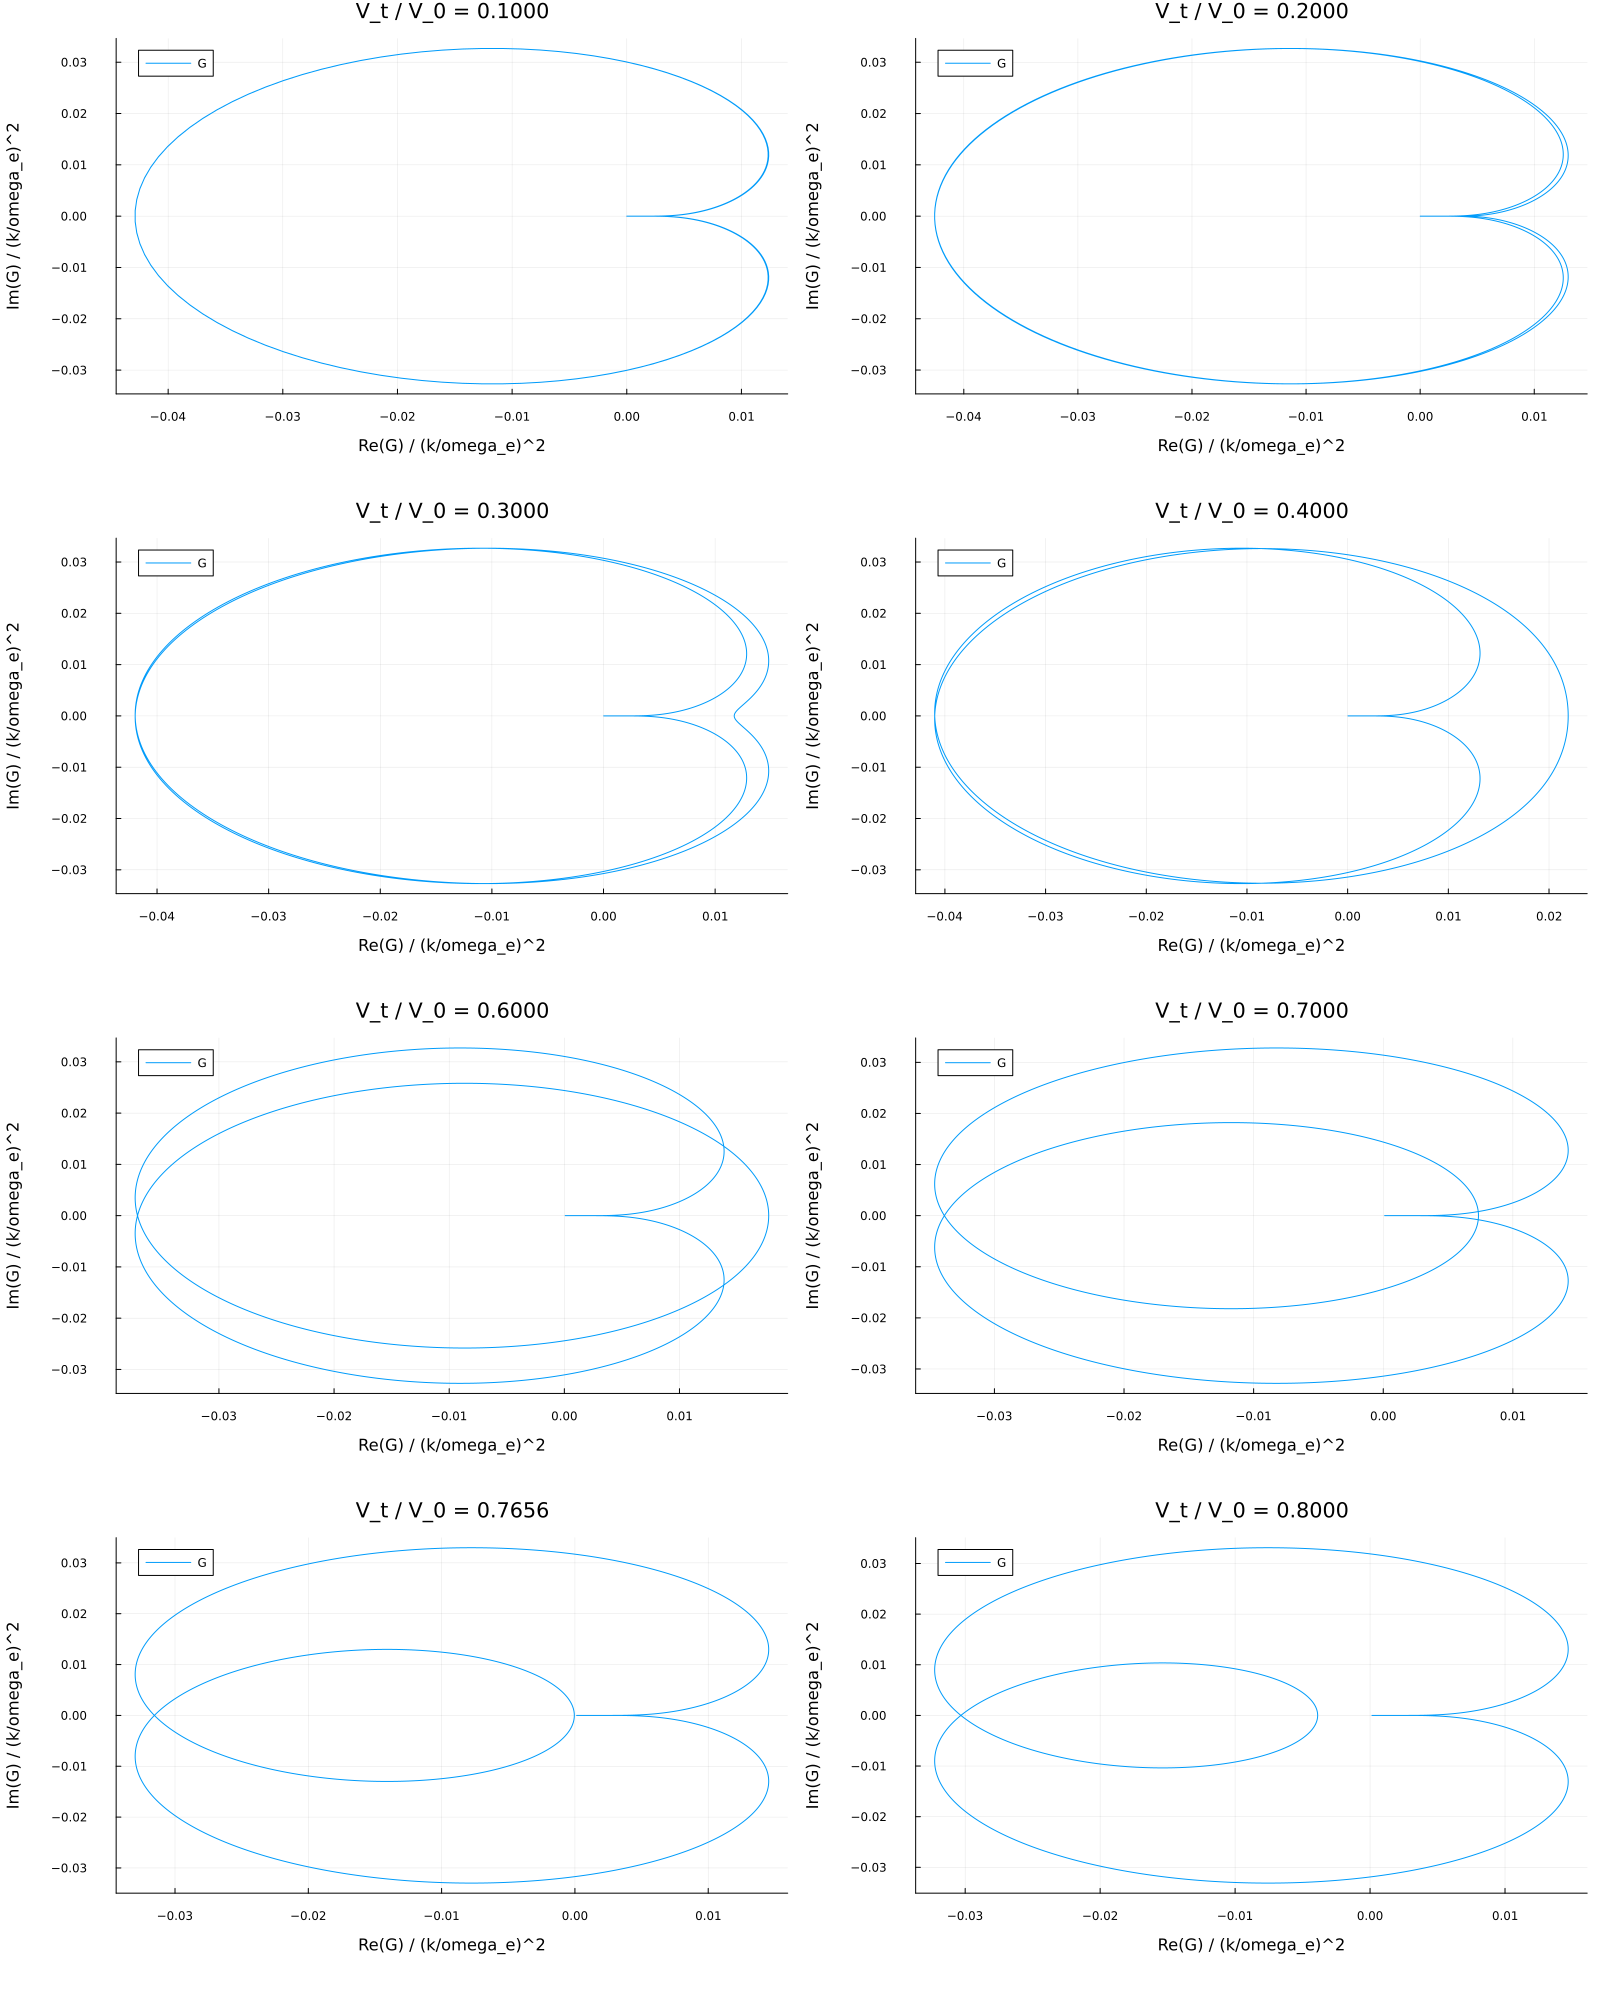

In [7]:
k = 1.0 * omega_e / V_0

omega_scale = 20
temp_scales = [1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 7.6555, 8.0]

omega_arr = collect(range(- omega_scale * omega_e,stop=omega_scale* omega_e, length=10000))


plots = []

for temp_scale in temp_scales
    v_t_e_new = v_t_e * temp_scale
    v_t_p_new = v_t_p * temp_scale 
    debye_e_new = v_t_e / omega_e
    debye_i_new = v_t_p / omega_p




    G = full_dispertion_relation.(omega_arr, k, V_0, v_t_e_new, v_t_p_new, debye_e_new, debye_i_new)

    G_scaled  = G /  (k / omega_e)^2;
    println(G_scaled[1:10])

    ratio = 1e-1 * temp_scale

    ratio_string = @sprintf("%.4f" , ratio)

    p = plot(G_scaled, xlabel="Re(G) / (k/omega_e)^2", ylabel="Im(G) / (k/omega_e)^2", label="G", title="V_t / V_0 = $ratio_string")
    push!(plots, p)
end

p = plot(plots..., layout=(4,2), size=(1600,2000), left_margin=10mm, bottom_margin= 10mm)
#savefig(p, "General_penrose.png")#, dpi=300)
